<a href="https://colab.research.google.com/github/dish-hash/Job-market/blob/main/big_data_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=ad91d2f33c0cfbe9678f38d1a1878282d470dc43e8f97eb2fbc029eed9e844c6
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Job Market Analysis").getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your CSV file


Saving Naukri_Data_Scientist_and_Data_Analytics_Jobs_Data.csv to Naukri_Data_Scientist_and_Data_Analytics_Jobs_Data.csv


In [ ]:
df = spark.read.option("header", "true").csv("Naukri_Data_Scientist_and_Data_Analytics_Jobs_Data.csv")
df.show(5)


+--------------------+--------------------+-------------------+-------------+--------------------+--------------------+
|          Job Titles|       Company Names|Experience Required|      Package|           Locations|              Skills|
+--------------------+--------------------+-------------------+-------------+--------------------+--------------------+
|Manager - Digital...|                Resy|            4-8 Yrs|Not disclosed|    Gurgaon/Gurugram|Product managemen...|
|Data Science Doma...|            Coursera|           7-11 Yrs|Not disclosed|Kolkata, Mumbai, ...|Computer scienceC...|
|GN - Strategy - M...|           Accenture|            1-3 Yrs|Not disclosed|Mumbai, Hyderabad...|Change management...|
|Data Science Manager|Foreign IT Consul...|            2-6 Yrs|Not disclosed|    Gurgaon/Gurugram|Operations resear...|
|Data Science Manager|Foreign IT Consul...|            3-6 Yrs|Not disclosed|               Noida|Data analysisEDCR...|
+--------------------+------------------

In [ ]:
df = df.na.drop()  # Drop rows with any null values


In [ ]:
from pyspark.sql.functions import regexp_replace, col

# Remove any non-numeric characters from the 'Package' column and create 'salary_clean'
df = df.withColumn("salary_clean", regexp_replace(col("Package"), "[^0-9]", "").cast("integer"))


In [ ]:
from pyspark.sql.functions import when, col

# Categorizing job titles into predefined categories based on the 'Job Titles' column
df = df.withColumn("job_category",
                   when(col("Job Titles").like("%Data Scientist%"), "Data Scientist")
                   .when(col("Job Titles").like("%Software Engineer%"), "Software Engineer")
                   .otherwise("Other"))


In [ ]:
df.printSchema()


root
 |-- Job Titles: string (nullable = true)
 |-- Company Names: string (nullable = true)
 |-- Experience Required: string (nullable = true)
 |-- Package: string (nullable = true)
 |-- Locations: string (nullable = true)
 |-- Skills: string (nullable = true)
 |-- salary_clean: integer (nullable = true)
 |-- job_category: string (nullable = false)



In [ ]:
from pyspark.sql.functions import lit

# Assuming data is from June 2023
df = df.withColumn("year", lit(2023))
df = df.withColumn("month", lit(6))

df.show(5)


+--------------------+--------------------+-------------------+-------------+--------------------+--------------------+------------+------------+----+-----+
|          Job Titles|       Company Names|Experience Required|      Package|           Locations|              Skills|salary_clean|job_category|year|month|
+--------------------+--------------------+-------------------+-------------+--------------------+--------------------+------------+------------+----+-----+
|Manager - Digital...|                Resy|            4-8 Yrs|Not disclosed|    Gurgaon/Gurugram|Product managemen...|        NULL|       Other|2023|    6|
|Data Science Doma...|            Coursera|           7-11 Yrs|Not disclosed|Kolkata, Mumbai, ...|Computer scienceC...|        NULL|       Other|2023|    6|
|GN - Strategy - M...|           Accenture|            1-3 Yrs|Not disclosed|Mumbai, Hyderabad...|Change management...|        NULL|       Other|2023|    6|
|Data Science Manager|Foreign IT Consul...|            2-6

In [ ]:
from pyspark.sql.functions import explode, split

# Split the 'Skills' column into individual skills, and explode into separate rows
skills_df = df.withColumn("skill", explode(split(col("Skills"), ",")))

# Group by skill and count the occurrences to find the most demanded skills
skill_demand = skills_df.groupBy("skill").count().orderBy("count", ascending=False)
skill_demand.show(10)  # Show top 10 most demanded skills


+--------------------+-----+
|               skill|count|
+--------------------+-----+
|                None|  183|
|Business AnalystB...|   38|
|Business Analystb...|   32|
|Product managemen...|   14|
|Junior StaffBusin...|   14|
|Business Analystp...|   14|
|data cleansingRep...|   12|
|Supply chainAutom...|   11|
|ProcurementData a...|   11|
|Data analysisAuto...|   10|
+--------------------+-----+
only showing top 10 rows



In [ ]:
# Group by 'job_category' and count the number of jobs in each category
job_category_trend = df.groupBy("job_category").count().orderBy("count", ascending=False)
job_category_trend.show()


+-----------------+-----+
|     job_category|count|
+-----------------+-----+
|            Other|17820|
|   Data Scientist| 1700|
|Software Engineer|  123|
+-----------------+-----+



In [ ]:
# Filter out rows where salary_clean is NULL
salary_df = df.filter(df.salary_clean.isNotNull())

# Group by 'job_category' to find average salary for each category
salary_trend = salary_df.groupBy("job_category").avg("salary_clean").orderBy("avg(salary_clean)", ascending=False)
salary_trend.show()


+-----------------+------------------+
|     job_category| avg(salary_clean)|
+-----------------+------------------+
|   Data Scientist|416060.37096774194|
|            Other| 309925.5460526316|
|Software Engineer| 92605.55555555556|
+-----------------+------------------+



In [ ]:
# Group by 'year' and 'month' to see how many jobs were posted in June 2023 (since all are 2023-06)
time_trend = df.groupBy("year", "month").count().orderBy("year", "month")
time_trend.show()


+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2023|    6|19643|
+----+-----+-----+



In [ ]:
# Explode skills column and group by job category and skill
skill_demand_by_category = skills_df.groupBy("job_category", "skill").count().orderBy("count", ascending=False)
skill_demand_by_category.show(10)  # Show top 10 demanded skills by job category


+------------+--------------------+-----+
|job_category|               skill|count|
+------------+--------------------+-----+
|       Other|                None|  182|
|       Other|Business AnalystB...|   38|
|       Other|Business Analystb...|   32|
|       Other|Product managemen...|   14|
|       Other|Business Analystp...|   14|
|       Other|Junior StaffBusin...|   13|
|       Other|ProcurementData a...|   11|
|       Other|data cleansingRep...|   11|
|       Other|Data analysisAuto...|   10|
|       Other|Help DeskCustomer...|   10|
+------------+--------------------+-----+
only showing top 10 rows



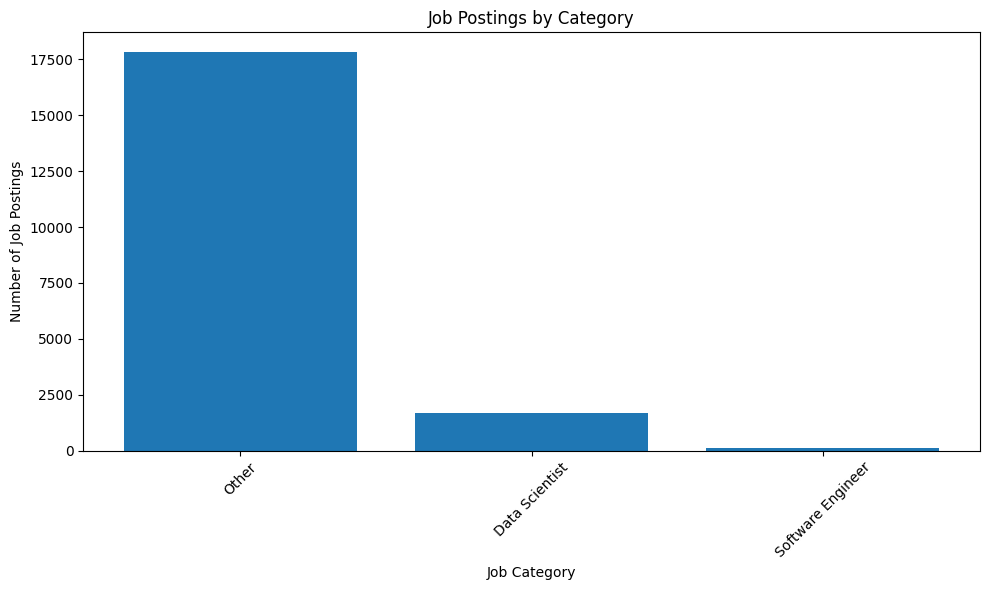

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame after grouping by job_category
job_category_trends = df.groupBy("job_category").count().orderBy("count", ascending=False)
job_category_trends_pd = job_category_trends.toPandas()

# Plot job category trends
plt.figure(figsize=(10,6))
plt.bar(job_category_trends_pd['job_category'], job_category_trends_pd['count'])
plt.xlabel('Job Category')
plt.ylabel('Number of Job Postings')
plt.title('Job Postings by Category')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()
